# Bayesian Neural Networks

Neural networks are powerful approximators. However, standard approaches for learning this approximators does not take into account the inherent uncertainty we may have when fitting a model. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import inferpy as inf

/Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/

## Data

We use some fake data. As neural nets of even one hidden layer 
can be universal function approximators, we can see if we can 
train a simple neural network to fit a noisy sinusoidal data, like this:
    

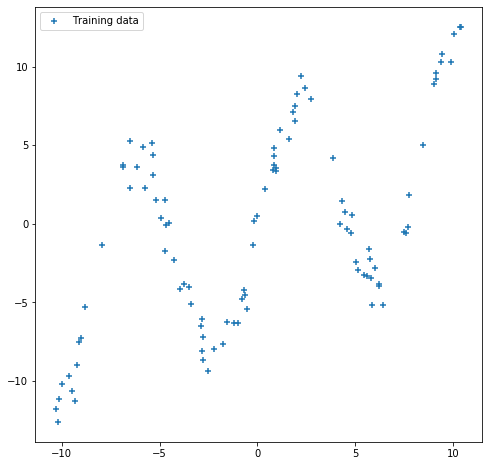

In [2]:
NSAMPLE = 100
x_train = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_train = np.float32(np.random.normal(size=(NSAMPLE,1),scale=1.0))
y_train = np.float32(np.sin(0.75*x_train)*7.0+x_train*0.5+r_train*1.0)

plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.legend();

## Training a neural network

We employ a simple feedforward network with 20 hidden units to try to fit the data. 


In [3]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])


NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

lossfunc = tf.nn.l2_loss(y_out-y);


train_op = tf.train.AdamOptimizer(0.01).minimize(lossfunc)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 1000
for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_train, y: y_train})
  if i%100==0: 
        print(sess.run(lossfunc,feed_dict={x: x_train, y: y_train}))


4082.5066
1241.7316
1149.0754
1026.4493
777.7458
512.65137
326.48676
211.95428
144.56673
105.36038


We see that the neural network can fit this sinusoidal data quite well, as expected. 

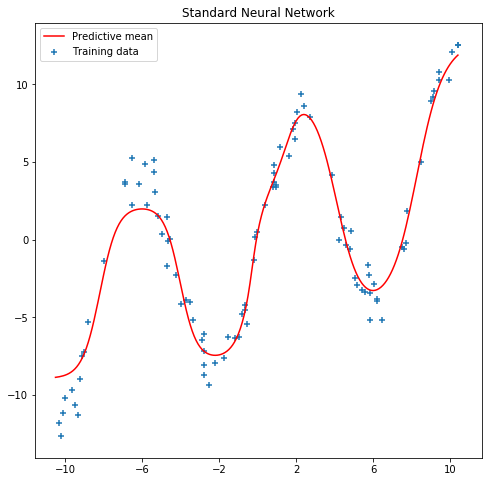

In [4]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_test, y_test, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xticks(np.arange(-10., 10.5, 4))
plt.title('Standard Neural Network')
plt.legend();
sess.close()

However this model is unable to capture the uncertainty in the model. For example, when making predictions about a single point (e.g. around x=2.0) we can see we do not account aobut the inherent noise there is in this predictions. In next section, we will what happen when we introduce a Bayesian approach using Inferpy. 

## Bayesian Learning of Neural Networks

[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a distribution over variables that are consistent with the observed data.

In Bayesian learning, the weights of the network are `random variables`. The output of the nework is another `random variable`. And the random variable of the output is the one that implicitlyl defines the ``loss function``. So, when making Bayesian learning we do not define ``loss functions``, we do define ``random variables``. For more information you can check [this talk](https://www.cs.ox.ac.uk/people/yarin.gal/website/PDFs/2017_OReilly_talk.pdf) and this [paper](https://arxiv.org/abs/1908.03442).

In [Inferpy](https://inferpy.readthedocs.io), defining a Bayesian neural network is quite straightforward. First we 
define our model, where the weights of the neural network are defined as random variables. Second, the input `x` and output `y` are also define as random variables. More precisely, the output `y` is defined as a Gaussian random varible. The mean of the Gaussian is the output of the neural network.

In [5]:
@inf.probmodel
def model(NHIDDEN):
    W = inf.Normal(loc = tf.zeros([1,NHIDDEN]), scale=1., name="W")
    b = inf.Normal(loc = tf.zeros([1,NHIDDEN]), scale=1., name="b")

    W_out = inf.Normal(loc = tf.zeros([NHIDDEN,1]), scale=1., name="W_out")
    b_out = inf.Normal(loc = tf.zeros([1,1]), scale=1., name="b_out")

    with inf.datamodel():
        x = inf.Normal(loc = tf.zeros([1]), scale = 1.0, name="x")
        hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
        out = tf.matmul(hidden_layer,W_out) + b_out
        y = inf.Normal(loc = out , scale= 1., name="y")

To perform Bayesian learning, we resort the scalable variational methods available in Inferpy, which require the definition of a `q` model. For details,see the documentation about [Inference in Inferpy](https://inferpy.readthedocs.io/projects/develop/en/develop/notes/guideinference.html). For a deeper theoretical despcription, read this [paper](https://arxiv.org/abs/1908.03442).

In [6]:
@inf.probmodel
def qmodel(NHIDDEN):
    W_loc = inf.Parameter(tf.random_normal([1,NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    b_loc = inf.Parameter(tf.random_normal([1,NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    W_scale = tf.nn.softplus(inf.Parameter(tf.random_normal([1,NHIDDEN], -10., stddev=0.05 ,dtype=tf.float32)))+0.01
    b_scale = tf.nn.softplus(inf.Parameter(tf.random_normal([1,NHIDDEN],  -10., stddev=0.05 ,dtype=tf.float32)))

    qW = inf.Normal(W_loc, scale = W_scale, name="W")
    qb = inf.Normal(b_loc, scale = b_scale, name="b")

    W_out_loc = inf.Parameter(tf.random_normal([NHIDDEN,1], 0.0, 0.05, dtype=tf.float32))
    b_out_loc = inf.Parameter(tf.random_normal([1,1], 0.0, 0.05, dtype=tf.float32))
    W_out_scale = tf.nn.softplus(inf.Parameter(tf.random_normal([NHIDDEN,1],  -10., stddev=0.05, dtype=tf.float32)))
    b_out_scale = tf.nn.softplus(inf.Parameter(tf.random_normal([1,1],  -10., stddev=0.05, dtype=tf.float32)))

    qW_out = inf.Normal(W_out_loc, scale = W_out_scale, name="W_out")
    qb_out = inf.Normal(b_out_loc, scale = b_out_scale, name="b_out")

In [7]:
NHIDDEN=20

p = model(NHIDDEN)
q = qmodel(NHIDDEN)

VI = inf.inference.VI(q, optimizer = tf.train.AdamOptimizer(0.01), epochs=5000)

p.fit({"x": x_train, "y": y_train}, VI)

W0915 00:06:14.661092 140736495002560 deprecation_wrapper.py:119] From /Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/inferpy/models/prob_model.py:62: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0915 00:06:14.688549 140736495002560 deprecation_wrapper.py:119] From /Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/inferpy/models/random_variable.py:430: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W0915 00:06:14.739406 140736495002560 deprecation_wrapper.py:119] From /Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0915 00:06:15.113492 140736495002560 deprecation_wrapper.py:119] From /Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/inferpy/models/prob_model.py:128


 0 epochs	 4250.9833984375....................
 200 epochs	 3586.171142578125....................
 400 epochs	 2556.68212890625....................
 600 epochs	 2355.43701171875....................
 800 epochs	 2267.65576171875....................
 1000 epochs	 2265.527587890625....................
 1200 epochs	 2245.12841796875....................
 1400 epochs	 2242.889892578125....................
 1600 epochs	 2235.450439453125....................
 1800 epochs	 2263.709228515625....................
 2000 epochs	 2295.6044921875....................
 2200 epochs	 2240.257080078125....................
 2400 epochs	 2290.189208984375....................
 2600 epochs	 2244.91552734375....................
 2800 epochs	 2256.49658203125....................
 3000 epochs	 2243.224609375....................
 3200 epochs	 2240.2900390625....................
 3400 epochs	 2242.430908203125....................
 3600 epochs	 2243.386474609375....................
 3800 epochs	 2243.115966796875..

As can be seen in the nex figure, the output of our model is not deterministic. So, we can caputure the uncertainty in the data. See for example what happens now with the predictions at the point `x=2.0`. See also what happens with the uncertainty in out-of-range predictions.

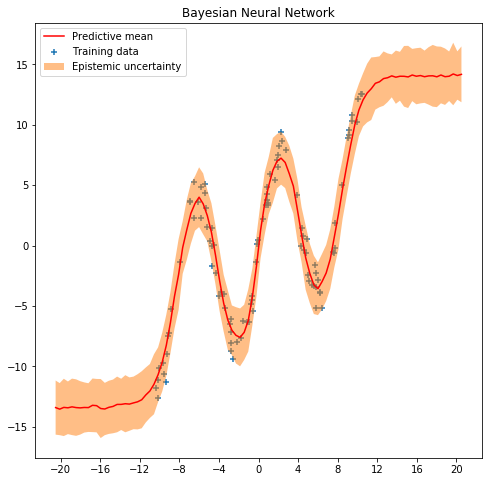

In [8]:
x_test = np.linspace(-20.5, 20.5, NSAMPLE).reshape(-1, 1)

plt.figure(figsize=(8, 8))

y_pred_list = []
for i in range(100):
    y_test = p.posterior_predictive(["y"], data = {"x": x_test}).sample()
    y_pred_list.append(y_test)

y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.xticks(np.arange(-20., 20.5, 4))
plt.title('Bayesian Neural Network')
plt.legend();